In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import Tensor, nn
from torchvision import datasets, transforms
from torch.cuda import is_available
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import random_split

/home/jupyter-tfg2324dm/.conda/envs/envDM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyperparameters

In [2]:
# training hyperparameters
batch_size = 128
n_epoch = 100
learning_rate = 1e-3
# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # label vector is of size 5
height = 16 # 16x16 image
save_dir = './weights/'
# diffusion hyperparameters
timesteps = 500

# Diffusion Model

## Class

In [3]:
class Diffusion_Models():
  # return beta_sqrt, alpha, alpha_sqrt, gamma, gamma_sqrt for noise and denoise image
  def __init__(self, timesteps, beta1=1e-4, beta2=0.02):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    beta = torch.linspace(beta1, beta2, timesteps + 1, device='cpu')
    alpha = 1 - beta
    one_by_sqrt_alpha = 1./alpha.sqrt()
    gamma = torch.cumprod(alpha, axis=0)
    gamma[0] = 1
    sqrt_one_minus_gamma = (1. - gamma).sqrt()
    beta_by_sqrt_one_minus_gamma = beta/sqrt_one_minus_gamma
    self.noise_schedule_dict = {'alpha':alpha, 'sqrt_alpha':alpha.sqrt(),
                   'beta':beta, 'sqrt_beta':beta.sqrt(),
                   'gamma':gamma, 'sqrt_gamma':gamma.sqrt(),
                   'one_by_sqrt_alpha':one_by_sqrt_alpha,
                   'sqrt_one_minus_gamma':sqrt_one_minus_gamma,
                   'beta_by_sqrt_one_minus_gamma':beta_by_sqrt_one_minus_gamma}
    self.timesteps = timesteps
    self.transform = transforms.Compose([
          transforms.Normalize(0.5,0.5)
          ])

  def show_noise_schedule(self):
    rows = 5
    cols = 2
    plt.figure(figsize=(16,16))
    for i, schedule in enumerate(self.noise_schedule_dict):
      plt.subplot(rows, cols, i + 1)
      plt.title(schedule)
      curr_schedule = self.noise_schedule_dict[schedule]
      plt.plot(curr_schedule)

  def show_noise_schedule2(self):
    for i, schedule in enumerate(self.noise_schedule_dict):
      plt.figure(figsize=(4,4))
      plt.title(schedule)
      curr_schedule = self.noise_schedule_dict[schedule]
      plt.plot(curr_schedule)

  def noise_image(self, x_0, time, noise=None):
    if noise is None:
      noise = torch.randn_like(x_0)
    img = self.noise_schedule_dict['sqrt_gamma'].to(self.device)[time, None, None, None] * x_0.to(self.device) + (self.noise_schedule_dict['sqrt_one_minus_gamma'].to(self.device)[time, None, None, None]) * noise.to(self.device)
    return img

  def unorm(self, img):
    img = torch.tensor(img)
    img = torch.clamp(img, -1.,1.)
    min, max = torch.aminmax(img)
    img = (img - min)/(max-min)
    return img

  def simulate_forward_diffusion(self, time_step, dataset, image=None, num_images=10):
    plt.figure(figsize=(num_images*2, 2))
    if image is None:
      idx = np.random.randint(len(dataset))
      image, curr_label = dataset[idx]
    stepsize = int(time_step/num_images)
    steps = range(0, time_step, stepsize)
    for i, curr_time in enumerate(steps):
      time = torch.Tensor([curr_time]).type(torch.int64)
      img = self.noise_image(image, time).to('cpu')
      img = self.unorm(img)
      plt.subplot(1, num_images + 1, i + 1)
      plt.axis('off')
      plt.title("time: {}".format(curr_time))
      plt.imshow(img[0].permute(1,2,0))

  def denoise_add_noise(self, x_t, t, pred_noise, z=None):
    if z is None:
      z = torch.randn_like(x_t)
    sqrt_beta = self.noise_schedule_dict['sqrt_beta'][t, None, None, None].to(self.device)
    noise = z.to(self.device) * sqrt_beta
    beta_by_sqrt_one_minus_gamma = self.noise_schedule_dict['beta_by_sqrt_one_minus_gamma'][t, None, None, None].to(self.device)
    pred_noise = pred_noise.to(self.device) * beta_by_sqrt_one_minus_gamma
    mean = (x_t - pred_noise) * self.noise_schedule_dict['one_by_sqrt_alpha'][t, None, None, None].to(self.device)
    if t > 1:
      x_t_minus_1 = mean + noise
    else:
      x_t_minus_1 = mean

    return x_t_minus_1

  # sample with context using standard algorithm
  @torch.no_grad()
  def sample_ddpm_context(self, model, n_sample, context, save_rate=100):
    # x_T
    samples = torch.randn(size=(n_sample, 3, height, height)).to(self.device)
    # arrays to keep track of generated steps for plotting
    self.intermediate = []
    self.intermediate_time = []
    for i in range(timesteps, 0, -1):
        # reshape time tensor
        t = torch.tensor([(i / timesteps)])[:, None, None, None].to(self.device)
        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else torch.zeros_like(samples)
        eps = model(samples, t, c=context)    # predict noise e_(x_t,t, ctx)
        samples = self.denoise_add_noise(samples, i, eps, z=z)
        if i % save_rate==0 or i==timesteps or i==1:
            self.intermediate.append(samples.detach().cpu().numpy())
            self.intermediate_time.append(i)
    self.intermediate = np.stack(self.intermediate)
    return samples

  def draw_samples_process(self, filename):
    cols = len(self.intermediate)
    rows = self.intermediate[0].shape[0]
    plt.figure(figsize=(cols*2, rows*2))
    for i, curr_imgs in enumerate(self.intermediate):
      curr_time = self.intermediate_time[i]
      for j, curr_img in enumerate(curr_imgs):
        curr_img = self.unorm(curr_img)
        plt.subplot(rows, cols, (j*cols) + i + 1)
        plt.axis('off')
        plt.title("time: {}".format(curr_time))
        plt.imshow(curr_img.permute(1,2,0))
    plt.savefig(f'./{filename}.png')

In [4]:
df = Diffusion_Models(timesteps)

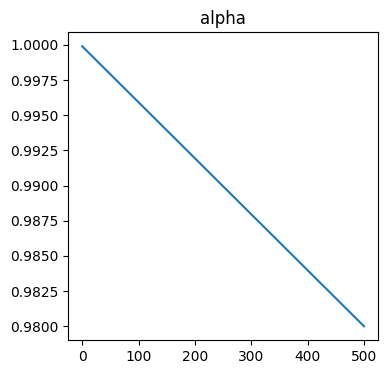

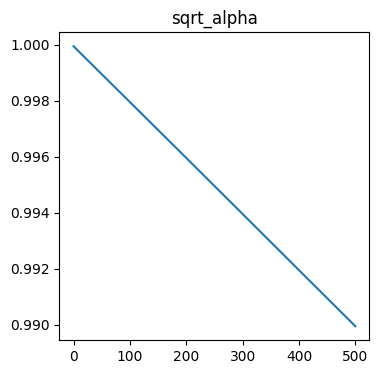

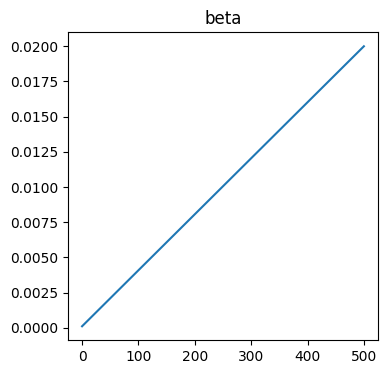

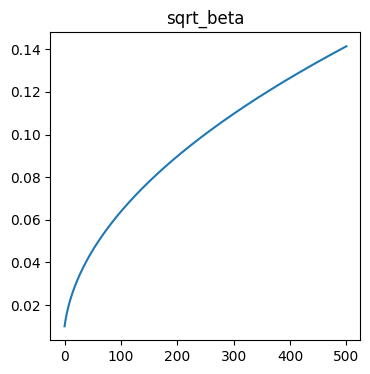

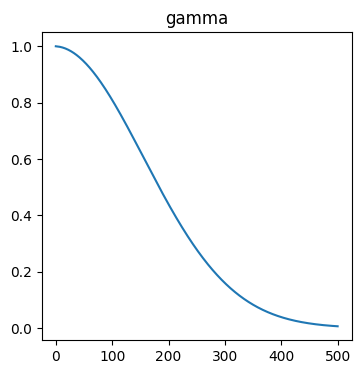

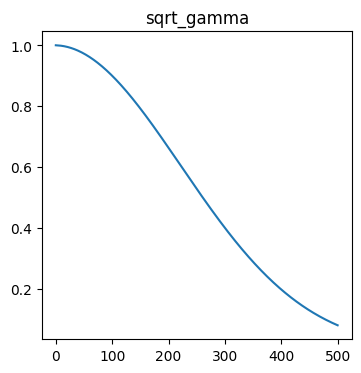

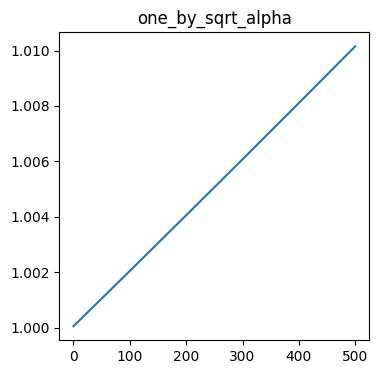

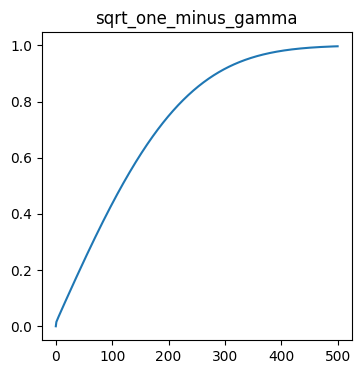

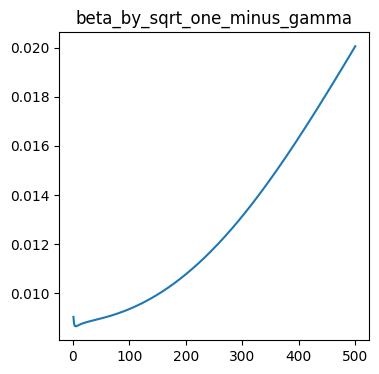

In [5]:
df.show_noise_schedule2()

## Noise schedule

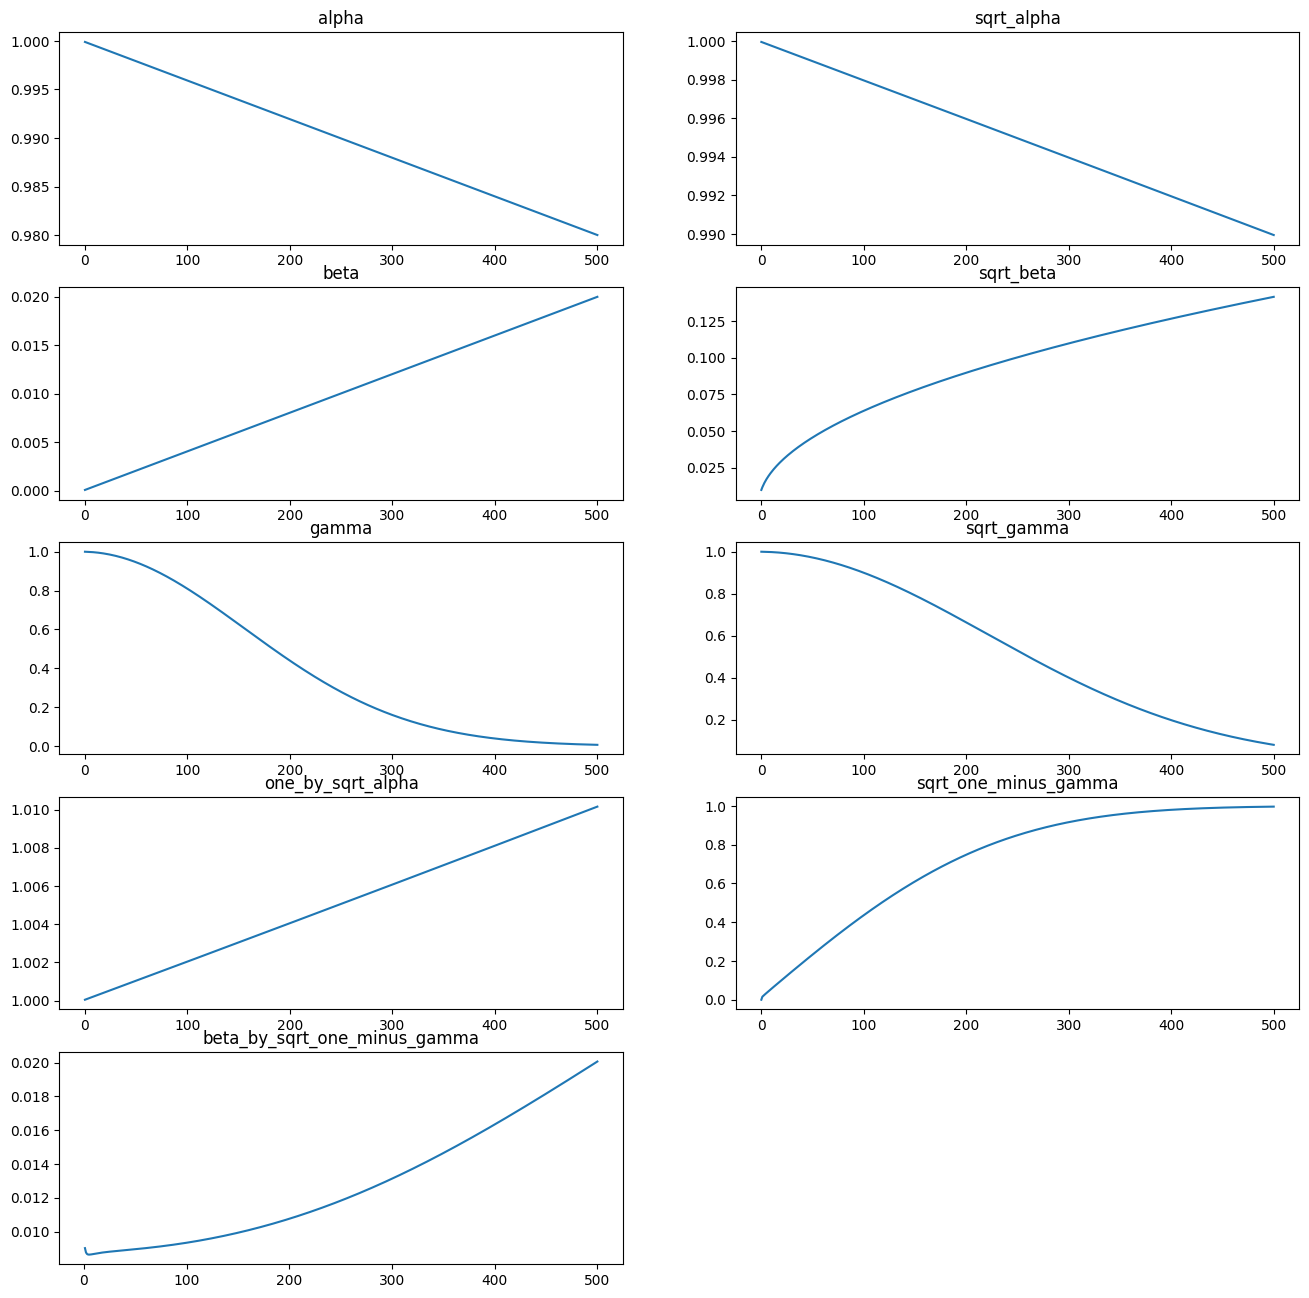

In [6]:
df.show_noise_schedule()

# Custom Dataset Class

In [7]:
class SpritesDataset(Dataset):
  def __init__(self, sfilename, lfilename, transform=None, null_context=False):
    self.sprites = np.load(sfilename)
    self.slabels = np.load(lfilename)
    self.null_context = null_context
    self.sprites_shape = self.sprites.shape
    self.slabel_shape = self.slabels.shape
    if transform is None:
      self.transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(0.5,0.5)
          ])
    else:
      self.transform = transform

  # Return the number of images in the dataset
  def __len__(self):
    return len(self.sprites)

  # Get the image and label at a given index
  def __getitem__(self, idx):
    # Return the image and label as a tuple
    image = self.transform(self.sprites[idx])
    if self.null_context:
      label = torch.tensor(0).to(torch.int64)
    else:
      label = torch.tensor(self.slabels[idx])
    return (image, label)

  # Get the shapes of datas and labels
  def getshapes(self):
    # return shapes of data and labels
    return self.sprites_shape, self.slabel_shape

# Loader Dataset

In [16]:
# DataSet path
dataset_data_path = './sprites_1788_16x16.npy'
dataset_label_path = './sprite_labels_nc_1788_16x16.npy'
# load dataset
dataset = SpritesDataset(dataset_data_path, dataset_label_path)
generator1 = torch.Generator().manual_seed(42)
train_dataset, validation_dataset = random_split(dataset, [79400,10000], generator=generator1)
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=False)
dataloader_valid = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=False)

In [17]:
# data label: hero, non-hero, food, spell, side-facing
label = ['hero', 'non-hero', 'food', 'spell', 'side-facing']

In [8]:
from collections import Counter

In [ ]:
print(label)
print(f"DATASET SIZE: {dataset.__len__()}")
lista = list()

for _, lab in dataset:
  label_i = lab.argmax()
  lista.append(label_i.item())

label_count = Counter(lista)

for i, label in enumerate(label):
  print (f"{label}: {label_count[i]} ELEMENTS")

['hero', 'non-hero', 'food', 'spell', 'side-facing']
DATASET SIZE: 89400
hero: 8000 ELEMENTS
non-hero: 32400 ELEMENTS
food: 6000 ELEMENTS
spell: 35000 ELEMENTS
side-facing: 8000 ELEMENTS


# show sample

## function

In [8]:
# display samples from a dataset randomly using Gaussian distribution
def show_samples(self, num_samples=40, cols=10):
  """ Plots some samples from the dataset """
  rows = int(num_samples / cols)
  if num_samples%cols!=0:
    rows += 1
  plt.figure(figsize=(16,rows*2))
  random_idx = torch.randint(0,len(self.sprites),(num_samples,))
  for i, idx in enumerate(random_idx):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    img, curr_label = dataset[idx]
    img = df.unorm(img)
    plt.title(label[np.argmax(curr_label)])
    plt.imshow(img.permute(1,2,0))

## Try function

/tmp/ipykernel_759080/4289953353.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


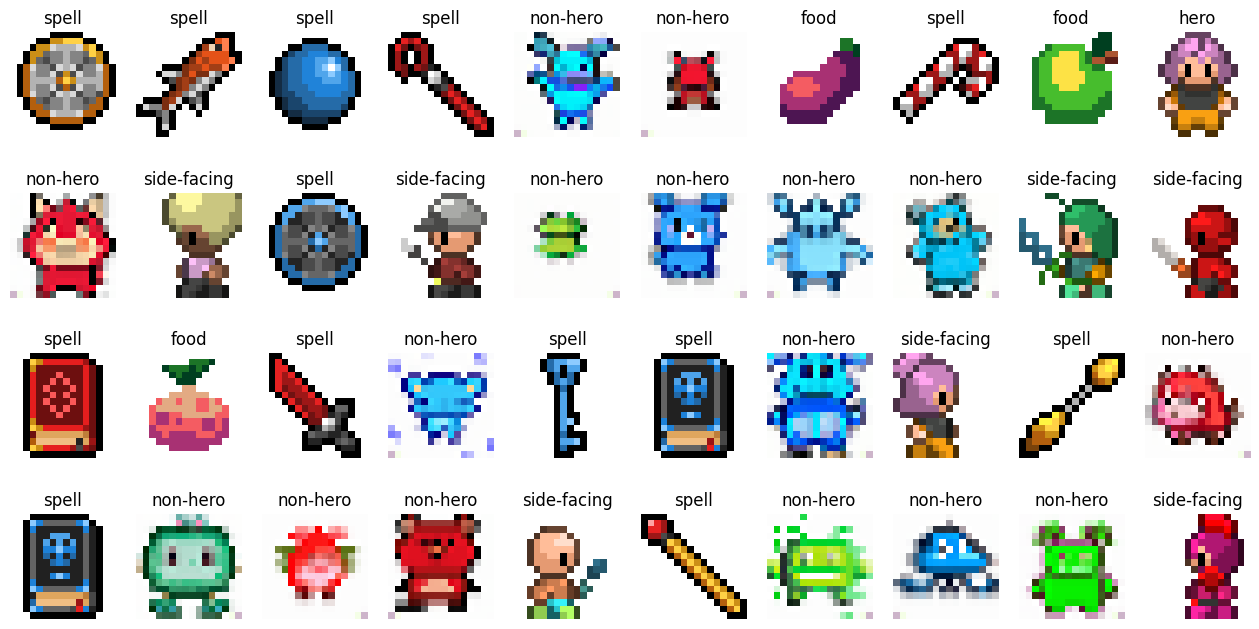

In [18]:
show_samples(dataset)

# simulate_forward_diffusion

/tmp/ipykernel_759080/4289953353.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


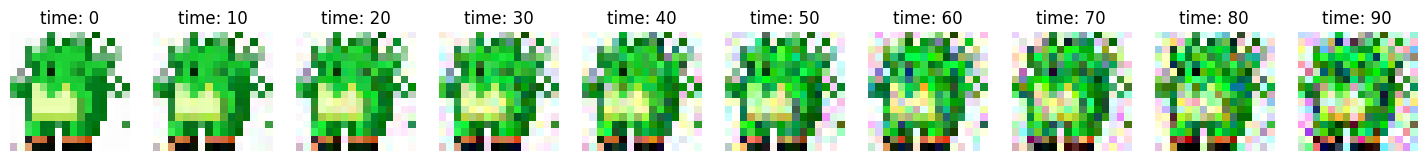

In [15]:
df.simulate_forward_diffusion(100, dataset)

/tmp/ipykernel_759080/4289953353.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


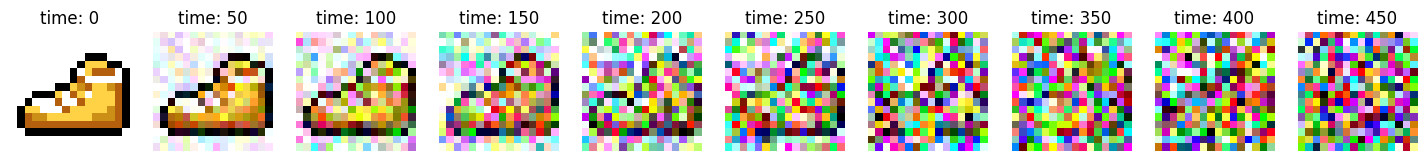

In [16]:
df.simulate_forward_diffusion(timesteps, dataset)

# Model (U-Net)

This model will be train for predict the noise of image

In [9]:
class Block(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, is_res: bool = False) -> None:
    super().__init__()

    # Check if input and output channels are not the same for the residual connection
    self.non_same_channels = in_channels != out_channels

    # Boolean to control if use or not residual connection
    self.is_res = is_res

    # First convolutional layer
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
         nn.BatchNorm2d(out_channels),   # Batch normalization
        nn.ReLU(),   # GELU activation function
        )

    # Second convolutional layer
    self.conv2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
         nn.BatchNorm2d(out_channels),   # Batch normalization
        nn.ReLU(),   # GELU activation function
        )

  def forward(self, x):
    # If using residual connection
    if self.is_res:
      x1 = self.conv1(x)
      x2 = self.conv2(x1)

      # If input and output channels are not the same, apply a 1x1 convolutional layer to match dimensions before adding residual connection
      if self.non_same_channels:
        shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
        x = shortcut(x) + x2
      out = x + x2
    # If not using residual connection, return output of second convolutional layer
    else:
      x1 = self.conv1(x)
      out = self.conv2(x1)
    return out

class UnetUp(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UnetUp, self).__init__()
    # The model consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
    self.model = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
        Block(out_channels, out_channels),
        Block(out_channels, out_channels)
        )

  def forward(self, x, skip):
    # Concatenate the input tensor x with the skip connection tensor along the channel dimension
    x = torch.cat((x, skip), 1)

    # Pass the concatenated tensor through the sequential model and return the output
    x = self.model(x)
    return x


class UnetDown(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UnetDown, self).__init__()
    # Each block consists of two Block layers, followed by a MaxPool2d layer for downsampling
    self.model = nn.Sequential(
        Block(in_channels, out_channels),
        Block(out_channels, out_channels),
        nn.MaxPool2d(2)
        )

  def forward(self, x):
    return self.model(x)

class EmbedFC(nn.Module):
  def __init__(self, input_dim, emb_dim):
    super(EmbedFC, self).__init__()
    #This class defines a generic one layer feed-forward neural network for embedding input data of
    #dimensionality input_dim to an embedding space of dimensionality emb_dim.
    self.input_dim = input_dim
    self.emb_dim = emb_dim
    self.model = nn.Sequential(
        nn.Linear(input_dim, emb_dim),
        nn.ReLU(),
        nn.Linear(emb_dim, emb_dim)
        )

  def forward(self, x):
    # flatten the input tensor
    x = x.view(-1, self.input_dim)
    # apply the model layers to the flattened tensor
    return self.model(x).view(-1, self.emb_dim, 1, 1)

In [10]:
class Unet(nn.Module):
  def __init__(self, in_channels, n_feat=64, n_cfeat=10, height=16):  # cfeat - context features
    super(Unet, self).__init__()
    # number of input channels, number of intermediate feature maps and number of classes
    self.in_channels = in_channels
    self.n_feat = n_feat
    self.n_cfeat = n_cfeat
    self.h = height  #assume h == w.

    # Initialize the initial convolutional layer
    self.init_conv = Block(in_channels, n_feat, is_res=True)

    # Initialize the down-sampling path of the U-Net with two levels
    self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 64, 8, 8]
    self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 128, 4, 4]

    # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.ReLU())
    self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.ReLU())

    # Embed the timestep and context labels with a one-layer fully connected neural network
    self.timeembed1 = EmbedFC(1, 2*n_feat)
    self.timeembed2 = EmbedFC(1, 1*n_feat)
    self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
    self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

    # Initialize the up-sampling path of the U-Net with three levels
    self.up0 = nn.Sequential(
        nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
        nn.BatchNorm2d(2 * n_feat), # normalize
        nn.ReLU(),
    )                                             # up0 #[10, 128+128, 4, 4]
    self.up1 = UnetUp(4 * n_feat, n_feat)         # up1 #[10, 64+64, 8, 8]
    self.up2 = UnetUp(2 * n_feat, n_feat)         # up2 #[10, 64, 16, 16]

    # Initialize the final convolutional layers to map to the same number of channels as the input image
    self.out = nn.Sequential(
        nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
        nn.ReLU(),
        nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
    )

  def forward(self, x, t, c=None):
    """
    x : (batch, n_feat, h, w) : input image
    t : (batch, n_cfeat)      : time step
    c : (batch, n_classes)    : context label
    """
    # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on
    # pass the input image through the initial convolutional layer
    x = self.init_conv(x)
    # pass the result through the down-sampling path
    down1 = self.down1(x)
    down2 = self.down2(down1)

    # convert the feature maps to a vector and apply an activation
    hiddenvec = self.to_vec(down2)
    # mask out context if context_mask == 1
    if c is None:
      c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

    # embed context and timestep with (batch, 2*n_feat, 1,1) for emb1 and (batch, n_feat, 1,1) for emb2
    cemb1 = self.contextembed1(c)
    temb1 = self.timeembed1(t)
    cemb2 = self.contextembed2(c)
    temb2 = self.timeembed2(t)

    up1 = self.up0(hiddenvec)
    up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
    up3 = self.up2(cemb2*up2 + temb2, down1)
    out = self.out(torch.cat((up3, x), 1))
    return out

# Training

## optimizer and loss function

In [12]:
model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
#model.load_state_dict(torch.load("context_model_trained.pth", map_location=device))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Start training

In [13]:
training_steps = 0
mean_loss_train = []
mean_loss_valid = []
for epoch in range(n_epoch):
    print("------ epoch {:03d} ------".format(epoch + 1))
    # linearly decay learning rate
    #optimizer.param_groups[0]['lr'] = learning_rate*(1-(epoch/n_epoch))
    total_loss = []
    model.train()
    for x_0, labels in dataloader_train:   # x_0: images
        optimizer.zero_grad()
        x_0 = x_0.to(device)
        # perturb data
        noise = torch.randn_like(x_0).to(device)
        t = torch.randint(1, timesteps + 1, (x_0.shape[0],)).to(device)
        x_t = df.noise_image(x_0, t, noise)
        # use network to recover noise
        pred_noise = model(x_t, t / timesteps, c=labels.float().to(device))

        # loss is measures the element-wise mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        training_steps+=1
        if (training_steps%100) == 0:
            print("Total train step: {}, Loss: {}".format(training_steps,loss))
    mean_loss_train.append(np.mean(total_loss))

    print("Total Loss: {}".format(mean_loss_train[-1]))
    # save model periodically
    if epoch%5==0 or epoch == int(n_epoch-1):
        torch.save(model.state_dict(), save_dir + "model_{:03d}.pth".format(epoch + 1))
        print('saved model at ' + save_dir + "model_{:03d}.pth".format(epoch + 1))
    model.eval()
    total_loss = []
    with torch.no_grad():
        for x_0, labels in dataloader_valid:
            x_0 = x_0.to(device)
            noise = torch.randn_like(x_0).to(device)
            t = torch.randint(1, timesteps + 1, (x_0.shape[0],)).to(device)
            x_t = df.noise_image(x_0, t, noise)
            # use network to recover noise
            pred_noise = model(x_t, t / timesteps, c=labels.float().to(device))

            # loss is measures the element-wise mean squared error between the predicted and true noise
            loss = F.mse_loss(pred_noise, noise)
            total_loss.append(loss.item())
        mean_loss_valid.append(np.mean(total_loss))

------ epoch 001 ------
Total train step: 100, Loss: 0.2596709728240967
Total train step: 200, Loss: 0.20031826198101044
Total train step: 300, Loss: 0.1804088056087494
Total train step: 400, Loss: 0.15422718226909637
Total train step: 500, Loss: 0.17403587698936462
Total train step: 600, Loss: 0.14648470282554626
Total Loss: 0.20645455182222544
saved model at ./weights/model_001.pth
------ epoch 002 ------
Total train step: 700, Loss: 0.14430344104766846
Total train step: 800, Loss: 0.1288183182477951
Total train step: 900, Loss: 0.11095643043518066
Total train step: 1000, Loss: 0.11203354597091675
Total train step: 1100, Loss: 0.11835406720638275
Total train step: 1200, Loss: 0.1465054750442505
Total Loss: 0.134706845977936
------ epoch 003 ------
Total train step: 1300, Loss: 0.1253594160079956
Total train step: 1400, Loss: 0.13068321347236633
Total train step: 1500, Loss: 0.14093780517578125
Total train step: 1600, Loss: 0.0989922285079956
Total train step: 1700, Loss: 0.1137768179

In [16]:
import matplotlib.pyplot as plt
def plot_train(J_train, J_cv, filename):
    plt.figure()
    plt.title("Train mean loss vs Validation mean loss")
    plt.plot(range(len(J_train)), J_train, color='blue', linestyle='-', linewidth=2.0, label="train mean loss")
    plt.plot(range(len(J_cv)), J_cv, color='red', linestyle='-', linewidth=2.0, label="validation mean loss")
    plt.legend()
    plt.savefig(f'./{filename}.png')
    plt.close()
plot_train(mean_loss_train, mean_loss_valid, "Train mean loss vs Validation mean loss per epoch")

# Sampling

In [26]:
model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
model.load_state_dict(torch.load(save_dir+"model_100.pth", map_location=device))

<All keys matched successfully>

In [170]:
def draw_samples_process(samples, ctx, filename):
    samples = samples.to("cpu")
    rows = samples.shape[0]
    print(samples.shape)
    plt.figure(figsize=(rows, 1))
    for i, curr_imgs in enumerate(samples):
        curr_img = df.unorm(curr_imgs)
        plt.subplot(1, rows, i+1)
        plt.axis('off')
        plt.imshow(curr_img.permute(1,2,0))
    plt.savefig(f'./{filename}.png')
    plt.close()

sin cambios

In [171]:
model.eval()
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,0,1,0],
    [0,0,0,0,1]
]).float().to(device)

samples = df.sample_ddpm_context(model, ctx.shape[0], ctx)
samples = samples.to("cpu")
draw_samples_process(samples,ctx,"All Class")

torch.Size([5, 3, 16, 16])


/tmp/ipykernel_774281/412254430.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


con cambios

In [172]:
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
]).float().to(device)

samples = df.sample_ddpm_context(model, ctx.shape[0], ctx)
draw_samples_process(samples,ctx,"Variety of hero")

torch.Size([6, 3, 16, 16])


/tmp/ipykernel_774281/412254430.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


In [173]:
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,1,0,0,0]
]).float().to(device)

samples = df.sample_ddpm_context(model, ctx.shape[0], ctx)
draw_samples_process(samples,ctx,"Variety of non-hero")

torch.Size([6, 3, 16, 16])


/tmp/ipykernel_774281/412254430.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


In [174]:
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0]
]).float().to(device)

samples = df.sample_ddpm_context(model, ctx.shape[0], ctx)
draw_samples_process(samples,ctx,"Variety of food")

torch.Size([6, 3, 16, 16])


/tmp/ipykernel_774281/412254430.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


In [175]:
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [0,0,0,1,0],
    [0,0,0,1,0],
    [0,0,0,1,0],
    [0,0,0,1,0],
    [0,0,0,1,0],
    [0,0,0,1,0]
]).float().to(device)

samples = df.sample_ddpm_context(model, ctx.shape[0], ctx)
draw_samples_process(samples,ctx,"Variety of spell")

torch.Size([6, 3, 16, 16])


/tmp/ipykernel_774281/412254430.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


In [176]:
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [0,0,0,0,1],
    [0,0,0,0,1],
    [0,0,0,0,1],
    [0,0,0,0,1],
    [0,0,0,0,1],
    [0,0,0,0,1]
]).float().to(device)

samples = df.sample_ddpm_context(model, ctx.shape[0], ctx)
draw_samples_process(samples,ctx,"Variety of side face")

torch.Size([6, 3, 16, 16])


/tmp/ipykernel_774281/412254430.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


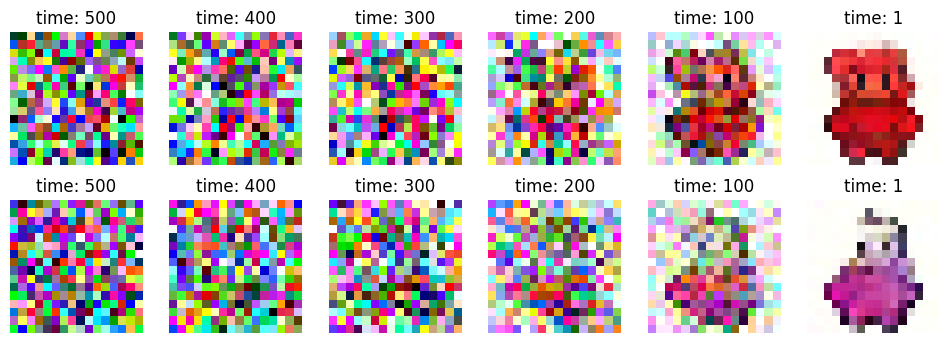

In [164]:
# data label: hero, non-hero, food, spell, side-facing
label = ['hero', 'non-hero', 'food', 'spell', 'side-facing']
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [0.6,0.4,0,0,0],
    [0.6,0.4,0,0,0],
]).float().to(device)

samples = df.sample_ddpm_context(model, ctx.shape[0], ctx)
df.draw_samples_process("Mixed Hero and Non-hero")

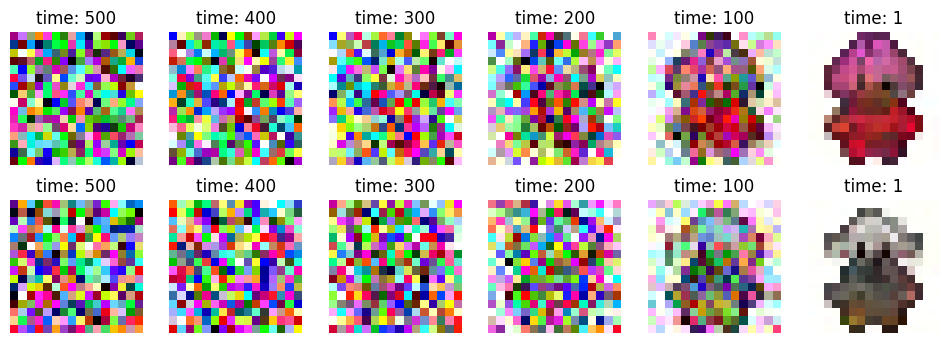

In [98]:
# data label: hero, non-hero, food, spell, side-facing
label = ['hero', 'non-hero', 'food', 'spell', 'side-facing']
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [0.5,0,0,0,0.5],
    [0.5,0,0,0,0.5],
]).float().to(device)

samples = df.sample_ddpm_context(model, ctx.shape[0], ctx)
df.draw_samples_process("Mixed Hero and side-facing")

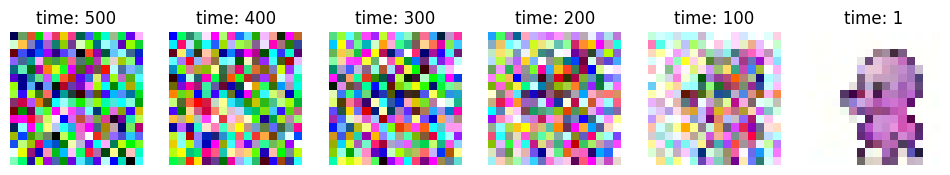

In [121]:
# data label: hero, non-hero, food, spell, side-facing
label = ['hero', 'non-hero', 'food', 'spell', 'side-facing']
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [0,0.4,0,0,0.6]
]).float().to(device)

samples = df.sample_ddpm_context(model, ctx.shape[0], ctx)
df.draw_samples_process("Mixed side-facing and non-hero")

In [44]:
for epoch in range(n_epoch):
    for x_0, labels in dataloader_train:   # x_0: images
        x_0 = x_0.to(device)
        # perturb data
        noise = torch.randn_like(x_0).to(device)
        t = torch.randint(1, timesteps + 1, (x_0.shape[0],)).to(device)
        x_t = df.noise_image(x_0, t, noise)
        print(x_t.shape)
        break
    break
draw_samples_process(x_t, t, "./entrada3", 4, labels)

torch.Size([16, 3, 16, 16])


/tmp/ipykernel_792678/412254430.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


In [40]:
def draw_samples_process(samples, ctx, filename, cols, labels):
    samples = samples.to("cpu")
    rows = int(samples.shape[0] / cols)
    if samples.shape[0]%cols!=0:
        rows += 1
    plt.figure(figsize=(10,rows*2))
    for i, curr_imgs in enumerate(samples):
        curr_img = df.unorm(curr_imgs)
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.title(f"{label[np.argmax(labels[i])]}, time: {ctx[i]}")
        plt.imshow(curr_img.permute(1,2,0))
    plt.savefig(f'./{filename}.png')
    plt.close()

In [ ]:
plt.title()